Noelle Landauer, 11/21/22

CIS277A, Lab8

Import modules and the heart data from .csv to Dataframe:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statistics import mean, stdev

In [2]:
heart = pd.read_csv(r".\heart.csv")
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Chest pain (cp) column codes:  Value 1: typical angina,  Value 2: atypical angina,  Value 3: non-anginal pain, Value 0 or 4: asymptomatic

I don't see any 4s at the top or bottom of heart['cp'], so check if asymptomatic == 4 is present in the dataset:

In [3]:
heart.query('cp == 4')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


No results, so check which codes actually are in heart['cp']:

In [4]:
heart['cp'].unique()

array([3, 2, 1, 0], dtype=int64)

Add four Boolean columns for chest pain (1=positive for condition).

In [5]:
def convert_cp(row, code):
    if row.cp == code:
        return 1
    else:
        return 0
    
heart['typical_angina'] = heart.apply(convert_cp, axis=1, code=1)
heart['atypical_angina'] = heart.apply(convert_cp, axis=1, code=2)
heart['non_aginal_pain'] = heart.apply(convert_cp, axis=1, code=3)
heart['asymptomatic'] = heart.apply(convert_cp, axis=1, code=0)
heart.head()        

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,typical_angina,atypical_angina,non_aginal_pain,asymptomatic
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,1,0,0,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1,0,0,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0,0,0,1


Heatmap correlating all columns to each other in the heart dataset:

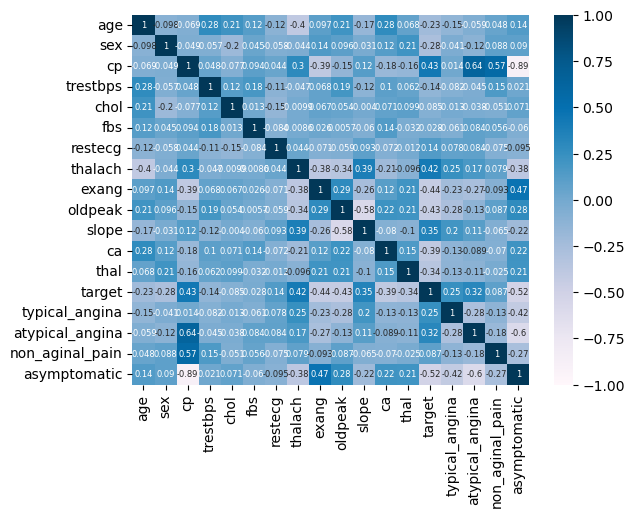

<Figure size 1344x576 with 0 Axes>

In [6]:
sns.heatmap(data=heart.corr(), 
            cmap='PuBu', 
            vmin=-1.0, 
            vmax=1.0, 
            annot=True, 
            annot_kws={"fontsize":6})
plt.figure(figsize=(14, 6), dpi=96)
plt.show()

Multivariate regression model for target (presence of heart disease) vs. all other variables. 

In [7]:
#list of column names minus 'target'
xCols = heart.corr().drop(columns=['target']).columns.tolist()

#split the dataset into train & test, random seed=1
xCols_train, xCols_test, target_train, target_test = train_test_split(heart[xCols], 
                                                    heart[['target']], 
                                                    test_size=0.1,
                                                    random_state=1)
# fit the model
model_all = LinearRegression()
model_all.fit(xCols_train, target_train)

#r2 scores from both train and test sets
print('Train score: ', round(model_all.score(xCols_train, target_train), 2))
print('Test score: ', round(model_all.score(xCols_test, target_test), 2))

# predicted values for the test set joined to original data
target_predicted = model_all.predict(xCols_test)
predicted_model_all = pd.DataFrame(target_predicted, columns=['predicted_target'])
final_model_all = predicted_model_all.join([xCols_test.reset_index(drop=True),
                                            target_test.reset_index(drop=True)])
final_model_all.head()[['predicted_target', 'target']]

Train score:  0.52
Test score:  0.53


,predicted_target,target
0,-0.186351,0
1,0.751673,1
2,0.166553,0
3,-0.118601,0
4,0.127612,0


Multivariate regression model including the top four most correlated factors (asymptomatic, exang, thalach, oldpeak). Technically cp (r<sup>2</sup> = 0.43) is slightly more correlated with target than thalach (0.42), but since asymptomatic is essentially a variation of cp with everyone with chest pain lumped together, they are strongly collinear (r<sup>2</sup> = 0.89), so I went with an uncorrelated variable as the fourth factor.

In [8]:
top4_train, top4_test, targ_train, targ_test = train_test_split(heart[['asymptomatic', 'exang', 'thalach', 'oldpeak']], 
                                                    heart[['target']], 
                                                    test_size=0.1, 
                                                   random_state=1)
model_top4 = LinearRegression()
model_top4.fit(top4_train, targ_train)
print('Train score: ', round(model_top4.score(top4_train, targ_train), 2))
print('Test score: ', round(model_top4.score(top4_test, targ_test), 2))

targ_predicted = model_top4.predict(top4_test)
predicted_model_top4 = pd.DataFrame(targ_predicted, columns=['predict_target'])
final_model_top4 = predicted_model_top4.join([top4_test.reset_index(drop=True),
                                       targ_test.reset_index(drop=True)])
final_model_top4.head()[['predict_target','target']]


Train score:  0.41
Test score:  0.36


,predict_target,target
0,-0.095123,0
1,0.915577,1
2,0.359018,0
3,0.064618,0
4,0.203274,0


Going in to the models, I thought it was likely that model_top4 would perform better than throwing everything at the wall in model_all. Either model_all would have too much noise and produce a low test score, or it would overfit its many variables and end up with an implausibly high score. Neither of these seems to be the case, though, and the model_all appears to have slightly better predictive power than model_top4. Perhaps it was able to glean more of a signal from all those variables than was apparent from the various low r2 correlations evident on the heat map. 

Neither model is particularly impressive, however, and their scores vary from run to run, depending on the random seed used. Out of curiosity, I ran both models in a loop 100 times and plopped the resulting test scores into two lists, in order to see the variation in performance across many trials. The data for that follows. Model_all still beats model_top4 across many trials (average r<sup>2</sup> = 0.49 vs. 0.41), with slightly lower standard deviation (0.11 vs. 0.13), indicating more variance with model_top4. You can see this play out on the plot, with more poor-performing runs with model_top4. However, from a predictive standpoint, it would work just as well to use a single factor ("asymptomatic," e.g. does the patient have chest pain or not), r<sup>2</sup> = 0.52. 

I would speculate that these results are a sign of an insufficient number of patients (rows) in the dataset. The original data had about 300 study participants, so when divided up 90/10 for train/test only leaves a group of 30 for the test set. It would be easy to end up with unbalanced target groups in the test set just by chance. So we end with the traditional scientist plea: more data needed.

Model_all mean:  0.49  sd:  0.11
Model_top4 mean:  0.41  sd:  0.13


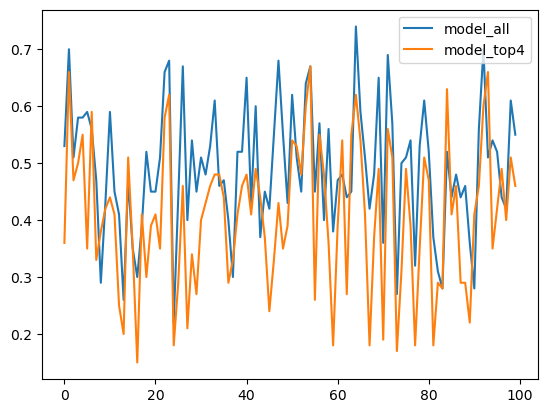

In [9]:
model_all_test_scores = []
model_top4_test_scores = []

for i in range(100):
    xCols_train, xCols_test, target_train, target_test = train_test_split(heart[xCols], 
                                                    heart[['target']], 
                                                    test_size=0.1,
                                                   random_state=(i+1))
    model_all = LinearRegression()
    model_all.fit(xCols_train, target_train)
    model_all_test_scores.append(round(model_all.score(xCols_test, target_test),2))
    
    top4_train, top4_test, targ_train, targ_test = train_test_split(heart[['asymptomatic', 'exang', 'thalach', 'oldpeak']], 
                                                    heart[['target']], 
                                                    test_size=0.1,
                                                   random_state=(i+1))
    model_top4 = LinearRegression()
    model_top4.fit(top4_train, targ_train)
    model_top4_test_scores.append(round(model_top4.score(top4_test, targ_test),2))

print("Model_all mean: ", round(mean(model_all_test_scores),2), " sd: ", round(stdev(model_all_test_scores),2))  
print("Model_top4 mean: ", round(mean(model_top4_test_scores),2), " sd: ", round(stdev(model_top4_test_scores),2))  
plt.plot(model_all_test_scores, label='model_all')
plt.plot(model_top4_test_scores, label='model_top4')
plt.legend()
plt.show()
